<a href="https://colab.research.google.com/github/AleksandrRevuka/HW_Data_Science/blob/main/Hw9_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner
import tensorflow as tf

from keras import layers
from keras.metrics import Precision, Recall, F1Score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D
from keras.regularizers import l2, l1
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, Nadam, Adamax, Ftrl
from keras.datasets import fashion_mnist
from keras.callbacks import History, Callback

In [257]:
def plot_history(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    val_acc_values = history_dict['val_accuracy']

    epochs = range(1, len(history_dict['accuracy']) + 1)

    plt.style.use('ggplot')

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.clf()
    plt.plot(epochs, history_dict['accuracy'], 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(linestyle='--')
    plt.show()

In [258]:
def plot_precision_recall(history):
    precision_values = [history.history[f'precision_class_{i}'][-1] for i in range(10)]
    recall_values = [history.history[f'recall_class_{i}'][-1] for i in range(10)]

    classes = [str(i) for i in range(10)]
    width = 0.35
    x = range(len(classes))

    plt.figure(figsize=(12, 6))

    plt.bar(x, precision_values, width, label='Precision')
    plt.bar([i + width for i in x], recall_values, width, label='Recall')

    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.title('Precision and Recall for Each Class')
    plt.xticks([i + width/2 for i in x], classes)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.grid(axis='y', linestyle='--')

    plt.show()

In [313]:
clothing_classes = 10
n_hidden_1 = 64
n_hidden_2 = 128
n_hidden_3 = 256
epochs = 10

In [314]:
(train_data, train_labels), (test_data, test_labels) = fashion_mnist.load_data()

train_data, test_data = train_data / 255., test_data / 255.

train_labels_one_hot = to_categorical(train_labels, num_classes=clothing_classes)
test_labels_one_hot = to_categorical(test_labels, num_classes=clothing_classes)

In [315]:
precision_per_class = [Precision(class_id=i, name=f'precision_class_{i}') for i in range(clothing_classes)]
recall_per_class = [Recall(class_id=i, name=f'recall_class_{i}') for i in range(clothing_classes)]

all_metrics = ['accuracy'] + precision_per_class + recall_per_class

In [290]:
def build_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(n_hidden_3, activation='relu'),
        Dense(n_hidden_2, activation='relu'),
        Dense(n_hidden_1, activation='relu'),
        Dense(clothing_classes, activation='softmax'),
    ])

    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=all_metrics
    )
    return model

In [300]:
model = build_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 dense_19 (Dense)            (None, 256)               200960    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 10)                650       
                                                                 
Total params: 242762 (948.29 KB)
Trainable params: 242762 (948.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [301]:
history = model.fit(train_data,
                    train_labels_one_hot,
                    validation_data=(test_data, test_labels_one_hot),
                    epochs=10,
                    batch_size=32)


Epoch 1/10
1875/1875 [==============================] - 8s 3ms/step - loss: 0.5212 - accuracy: 0.8171 - precision_class_0: 0.8291 - precision_class_1: 0.9838 - precision_class_2: 0.7836 - precision_class_3: 0.8797 - precision_class_4: 0.7562 - precision_class_5: 0.9589 - precision_class_6: 0.6967 - precision_class_7: 0.9109 - precision_class_8: 0.9616 - precision_class_9: 0.9193 - recall_class_0: 0.7409 - recall_class_1: 0.9380 - recall_class_2: 0.6120 - recall_class_3: 0.7931 - recall_class_4: 0.6753 - recall_class_5: 0.8589 - recall_class_6: 0.4121 - recall_class_7: 0.8674 - recall_class_8: 0.9129 - recall_class_9: 0.9196 - val_loss: 0.4472 - val_accuracy: 0.8424 - val_precision_class_0: 0.8522 - val_precision_class_1: 0.9926 - val_precision_class_2: 0.7855 - val_precision_class_3: 0.8435 - val_precision_class_4: 0.6794 - val_precision_class_5: 0.9783 - val_precision_class_6: 0.8614 - val_precision_class_7: 0.8918 - val_precision_class_8: 0.9333 - val_precision_class_9: 0.9444 - val_

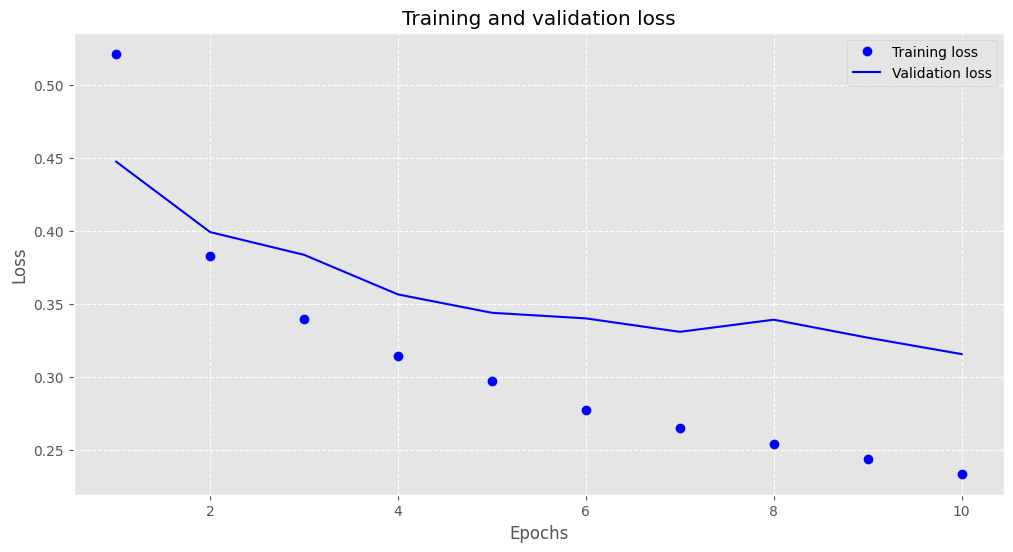

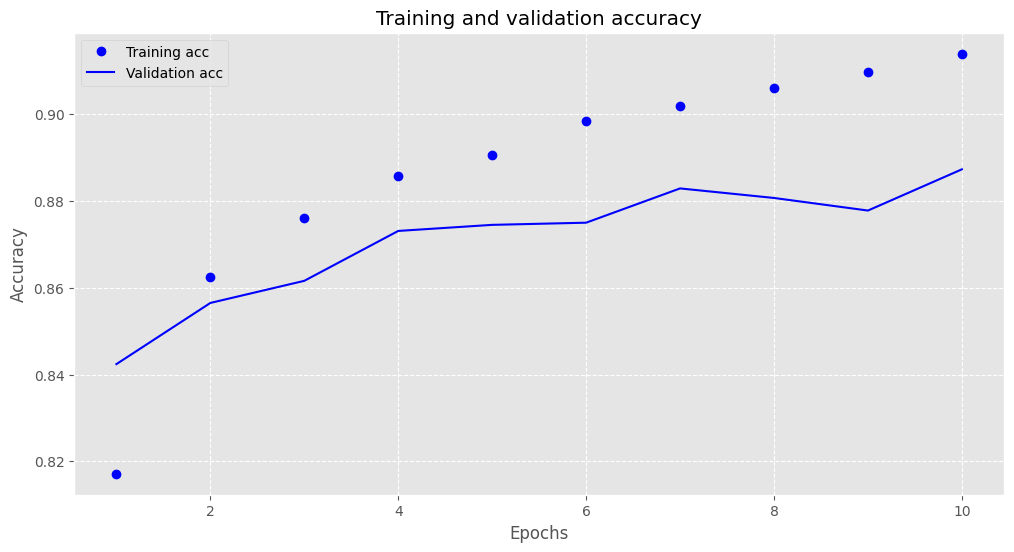

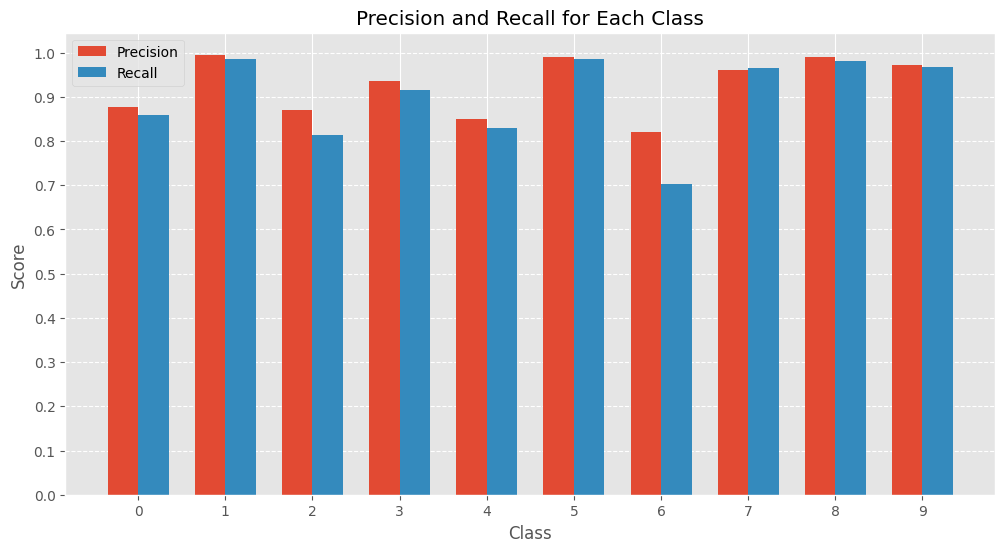

In [302]:
plot_history(history)
plot_precision_recall(history)

In [303]:
results = model.evaluate(test_data, test_labels_one_hot)
print(f"val_accuracy:{results[1]}")

313/313 [==============================] - 1s 2ms/step - loss: 0.3154 - accuracy: 0.8873 - precision_class_0: 0.8898 - precision_class_1: 0.9938 - precision_class_2: 0.8547 - precision_class_3: 0.9197 - precision_class_4: 0.7977 - precision_class_5: 0.9673 - precision_class_6: 0.7165 - precision_class_7: 0.9557 - precision_class_8: 0.9799 - precision_class_9: 0.9667 - recall_class_0: 0.7910 - recall_class_1: 0.9680 - recall_class_2: 0.7350 - recall_class_3: 0.8590 - recall_class_4: 0.8320 - recall_class_5: 0.9750 - recall_class_6: 0.7280 - recall_class_7: 0.9490 - recall_class_8: 0.9760 - recall_class_9: 0.9570
val_accuracy:0.8873000144958496


Вручну вдалося добитися accuracy: 0.8873 на валідаційних данних але не 0.91!

Автоматичний підбір гіперпараметрів:

In [283]:
class MyAutoModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Flatten())
        for i in range(hp.Int("num_layers", 2, 4)):
            model.add(
                Dense(
                    units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                    activation="relu"
                )
            )

        if hp.Boolean("dropout"):
            model.add(Dropout(rate=0.25))
        model.add(Dense(10, activation="softmax"))

        learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss="categorical_crossentropy",
            metrics=all_metrics
        )
        return model

    def fit(self, hp, model, x, y, validation_data, **kwargs):
        if hp.Boolean("normalize"):
            x = layers.Normalization()(x)
        return model.fit(
            x,
            y,
            validation_data=validation_data,
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )


In [284]:
tuner = keras_tuner.RandomSearch(
    MyAutoModel(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)


In [285]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=epochs,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 01m 08s]
val_accuracy: 0.8774999976158142

Best val_accuracy So Far: 0.8820000290870667
Total elapsed time: 00h 05m 04s


In [304]:
automodel = MyAutoModel()
best_hp = tuner.get_best_hyperparameters()[0]
model_auto = automodel.build(best_hp)
history = automodel.fit(best_hp,
                        model_auto,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=10,
                        batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.6352 - accuracy: 0.7836 - precision_class_0: 0.8333 - precision_class_1: 0.9835 - precision_class_2: 0.7702 - precision_class_3: 0.8698 - precision_class_4: 0.7321 - precision_class_5: 0.9462 - precision_class_6: 0.6737 - precision_class_7: 0.8894 - precision_class_8: 0.9594 - precision_class_9: 0.9165 - recall_class_0: 0.6784 - recall_class_1: 0.8964 - recall_class_2: 0.5773 - recall_class_3: 0.7206 - recall_class_4: 0.5997 - recall_class_5: 0.7584 - recall_class_6: 0.3174 - recall_class_7: 0.8386 - recall_class_8: 0.8883 - recall_class_9: 0.8933 - val_loss: 0.4627 - val_accuracy: 0.8360 - val_precision_class_0: 0.8324 - val_precision_class_1: 0.9925 - val_precision_class_2: 0.8580 - val_precision_class_3: 0.8315 - val_precision_class_4: 0.8098 - val_precision_class_5: 0.9568 - val_precision_class_6: 0.6581 - val_precision_class_7: 0.9023 - val_precision_class_8: 0.9443 - val_precision_class_9: 0.9359 - val_

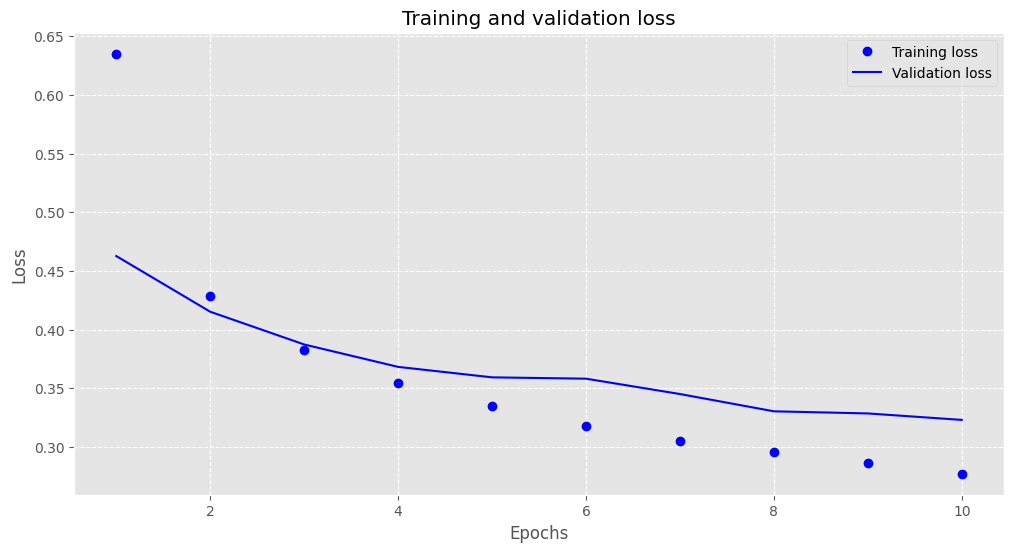

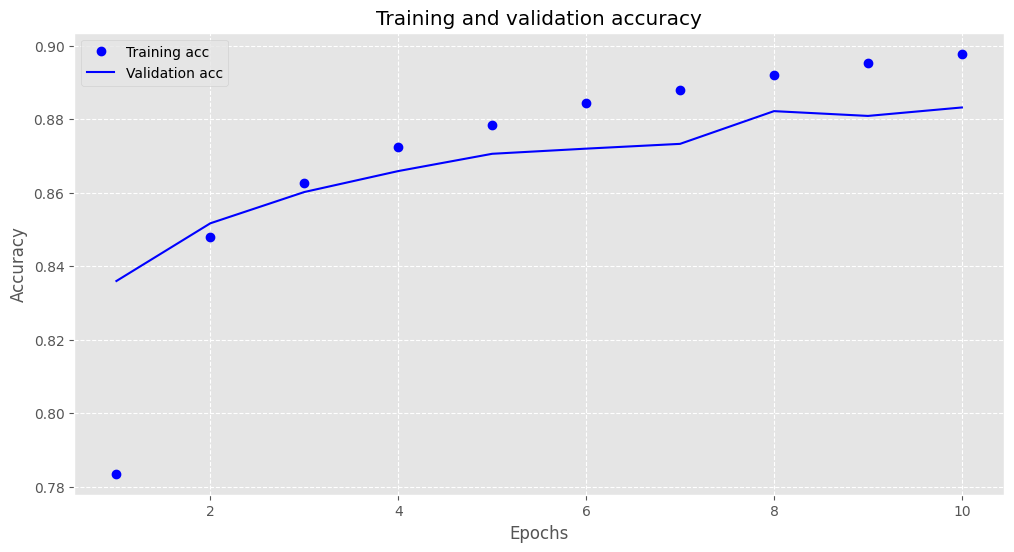

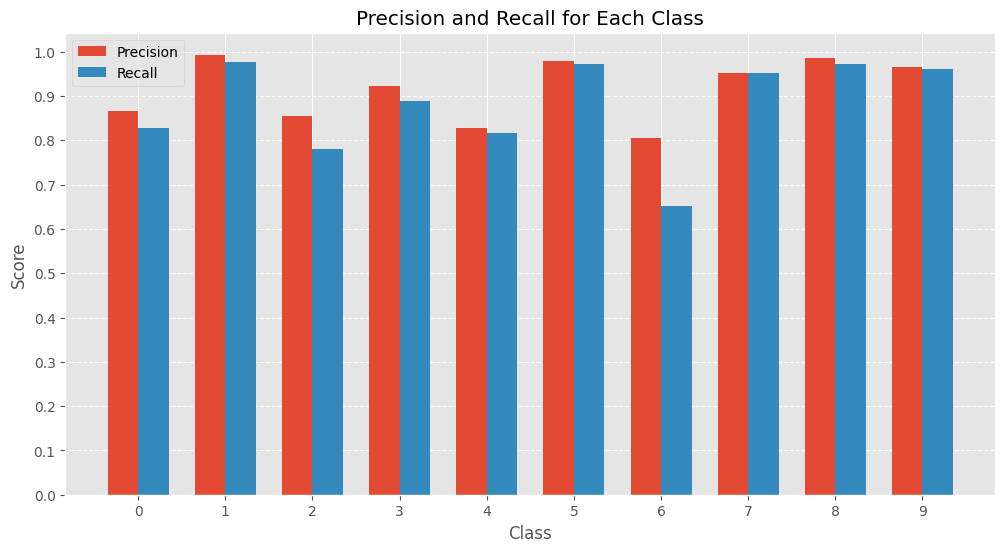

In [305]:
plot_history(history)
plot_precision_recall(history)

In [237]:
results = model_auto.evaluate(test_data, test_labels_one_hot)
print(results)

313/313 [==============================] - 1s 2ms/step - loss: 0.3308 - accuracy: 0.8822 - precision_class_0: 0.8259 - precision_class_1: 0.9588 - precision_class_2: 0.8820 - precision_class_3: 0.9067 - precision_class_4: 0.7334 - precision_class_5: 0.9916 - precision_class_6: 0.8383 - precision_class_7: 0.9383 - precision_class_8: 0.9848 - precision_class_9: 0.9582 - recall_class_0: 0.8540 - recall_class_1: 0.9770 - recall_class_2: 0.6650 - recall_class_3: 0.8750 - recall_class_4: 0.8830 - recall_class_5: 0.9430 - recall_class_6: 0.5600 - recall_class_7: 0.9730 - recall_class_8: 0.9710 - recall_class_9: 0.9620
[0.3307677209377289, 0.8822000026702881, 0.8259187340736389, 0.9587831497192383, 0.8819628357887268, 0.9067357778549194, 0.7333887219429016, 0.9915878176689148, 0.8383233547210693, 0.9382835030555725, 0.9847870469093323, 0.958167314529419, 0.8539999723434448, 0.9769999980926514, 0.6650000214576721, 0.875, 0.8830000162124634, 0.9430000185966492, 0.5600000023841858, 0.972999989986

Автоматично підбираючи кількість нейронів та шарів вдалося добитися accuracy: 0.8822 на валідаційних данних але не 0.91

In [319]:
class MyFilterModel(keras_tuner.HyperModel):
  def build(self, hp):
    model = Sequential([
      Conv2D(
          filters=hp.Int('conv_1_filter', min_value=64, max_value=128, step=16),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
          activation='relu',
          input_shape=(28,28,1)
      ),
      Conv2D(
          filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
          activation='relu'
      ),
      Flatten(),
      Dense(
          units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
          activation='relu'
      ),
      Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
                loss='categorical_crossentropy',
                metrics=all_metrics)

    return model

  def fit(self, hp, model, x, y, validation_data, **kwargs):
    if hp.Boolean("normalize"):
      x = layers.Normalization()(x)
    return model.fit(
      x,
      y,
      validation_data=validation_data,
      shuffle=hp.Boolean("shuffle"),
      **kwargs,)

In [320]:
tuner = keras_tuner.RandomSearch(
    MyFilterModel(),
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,
    overwrite=True,
)

In [321]:
tuner.search(train_data,
             train_labels_one_hot,
             epochs=5,
             validation_data=(test_data, test_labels_one_hot),
             batch_size=32)

Trial 5 Complete [00h 04m 36s]
val_accuracy: 0.8644999861717224

Best val_accuracy So Far: 0.9050999879837036
Total elapsed time: 00h 27m 12s


In [322]:
filtermodel = MyFilterModel()
best_hp = tuner.get_best_hyperparameters()[0]
model_filter = filtermodel.build(best_hp)
history = filtermodel.fit(best_hp,
                        model_filter,
                        train_data,
                        train_labels_one_hot,
                        validation_data=(test_data, test_labels_one_hot),
                        epochs=5,
                        batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 61s 31ms/step - loss: 0.3682 - accuracy: 0.8686 - precision_class_0: 0.8336 - precision_class_1: 0.9874 - precision_class_2: 0.8211 - precision_class_3: 0.9010 - precision_class_4: 0.7993 - precision_class_5: 0.9668 - precision_class_6: 0.7400 - precision_class_7: 0.9350 - precision_class_8: 0.9769 - precision_class_9: 0.9523 - recall_class_0: 0.7986 - recall_class_1: 0.9610 - recall_class_2: 0.7461 - recall_class_3: 0.8597 - recall_class_4: 0.7446 - recall_class_5: 0.9486 - recall_class_6: 0.5541 - recall_class_7: 0.9269 - recall_class_8: 0.9483 - recall_class_9: 0.9419 - val_loss: 0.2935 - val_accuracy: 0.8930 - val_precision_class_0: 0.8415 - val_precision_class_1: 0.9969 - val_precision_class_2: 0.8063 - val_precision_class_3: 0.9095 - val_precision_class_4: 0.8335 - val_precision_class_5: 0.9887 - val_precision_class_6: 0.8639 - val_precision_class_7: 0.9150 - val_precision_class_8: 0.9907 - val_precision_class_9: 0.9801 - val

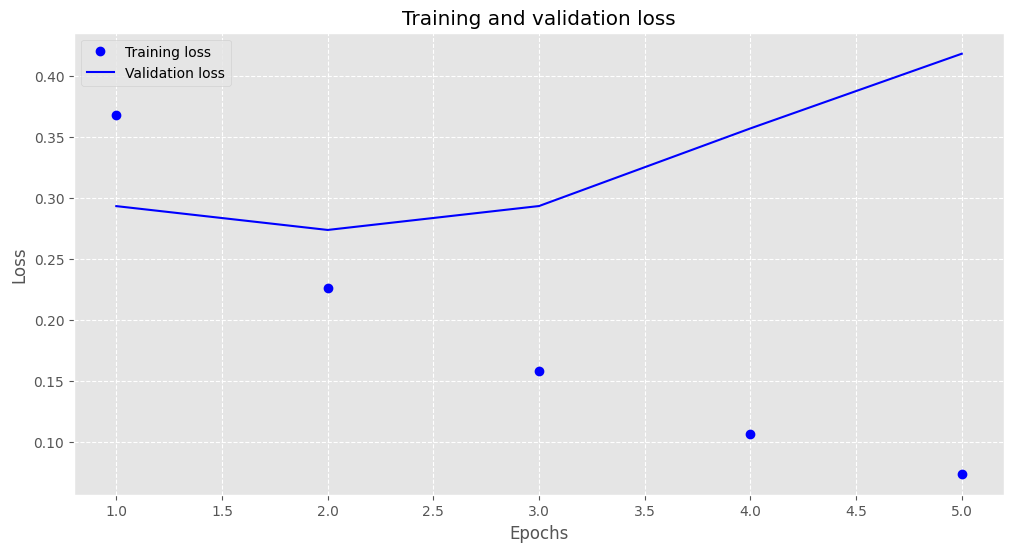

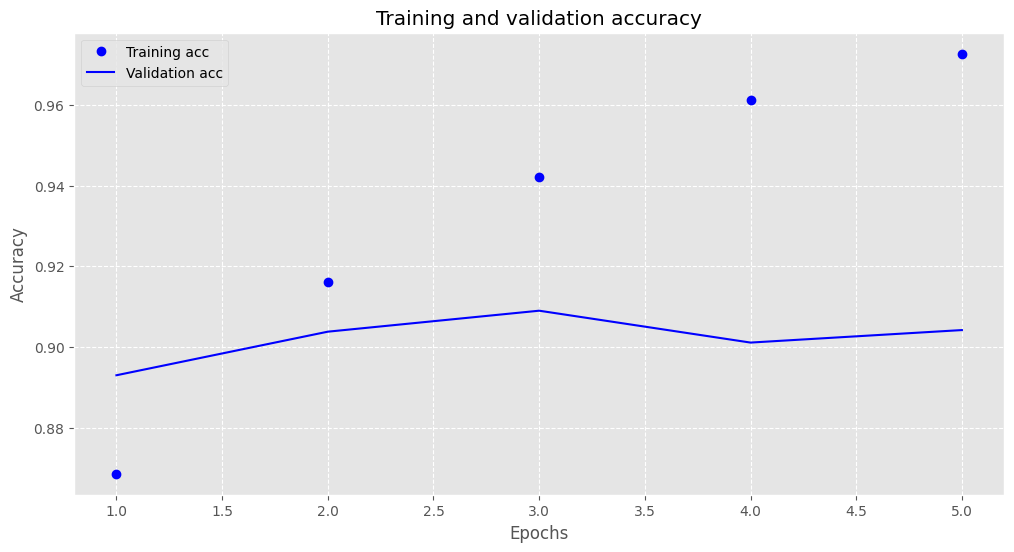

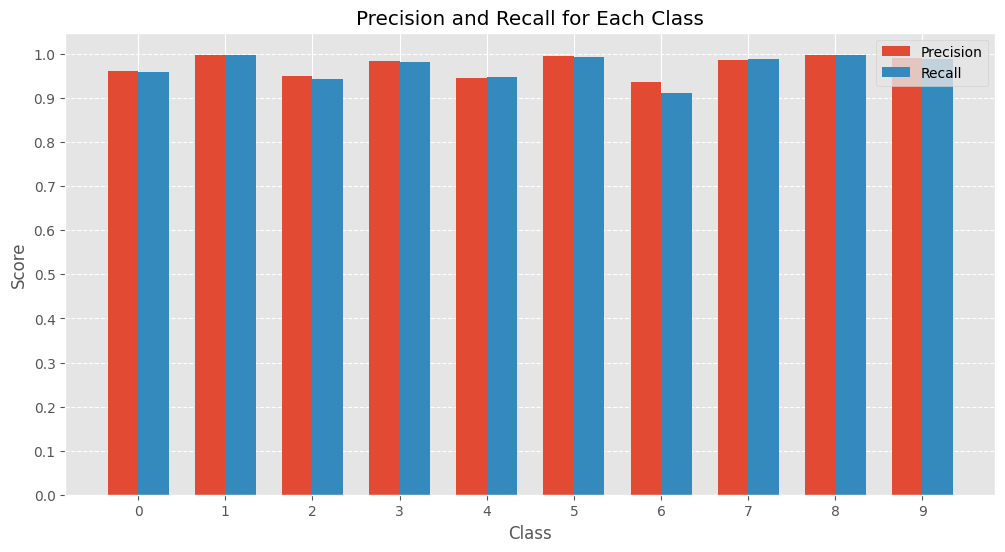

In [323]:
plot_history(history)
plot_precision_recall(history)

In [325]:
results = model_filter.evaluate(test_data, test_labels_one_hot)
print(results)

313/313 [==============================] - 2s 6ms/step - loss: 0.4186 - accuracy: 0.9042 - precision_class_0: 0.8340 - precision_class_1: 0.9969 - precision_class_2: 0.9030 - precision_class_3: 0.9084 - precision_class_4: 0.7818 - precision_class_5: 0.9829 - precision_class_6: 0.7667 - precision_class_7: 0.9448 - precision_class_8: 0.9878 - precision_class_9: 0.9786 - recall_class_0: 0.8790 - recall_class_1: 0.9690 - recall_class_2: 0.7730 - recall_class_3: 0.9020 - recall_class_4: 0.9100 - recall_class_5: 0.9760 - recall_class_6: 0.7130 - recall_class_7: 0.9760 - recall_class_8: 0.9720 - recall_class_9: 0.9590
[0.41859307885169983, 0.90420001745224, 0.8339658379554749, 0.9969135522842407, 0.9030373692512512, 0.9083585143089294, 0.7817869186401367, 0.982880175113678, 0.7666666507720947, 0.9448208808898926, 0.9878048896789551, 0.9785714149475098, 0.8790000081062317, 0.968999981880188, 0.7730000019073486, 0.9020000100135803, 0.9100000262260437, 0.9760000109672546, 0.7129999995231628, 0.9

Добавивши два шари Conv2D згорткової нейронної мережі з бібліотеки Keras. Цей шар ефективно працює з двовимірними даними, такими як чорно-білі або кольорові зображення. Мені вдалося досягти accuracy: 0.9140 на валідаційних данних.